In [1]:
import sys

import numpy
import torch
sys.path.append("..")
from mobile_encoder.setup_mobile_sam import setup_model
checkpoint = torch.load('../weights/mobile_sam.pt', map_location=torch.device('cpu'))
mobile_sam = setup_model()
mobile_sam.load_state_dict(checkpoint,strict=True)

/Users/jameskelly/miniconda3/envs/sam/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/Users/jameskelly/miniconda3/envs/sam/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c106detail19maybe_wrap_dim_slowIxEET_S2_S2_b
  Referenced from: <9A4710B9-0DA3-36BB-9129-645F282E64B2> /Users/jameskelly/miniconda3/envs/sam/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <1E9FA061-EA31-3736-81D0-79A33B965097> /Users/jameskelly/miniconda3/envs/sam/lib/python3.10/site-packages/torch/lib/libc10.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


LR SCALES: [0.08589934592000005, 0.10737418240000006, 0.13421772800000006, 0.1677721600000001, 0.20971520000000007, 0.2621440000000001, 0.3276800000000001, 0.4096000000000001, 0.5120000000000001, 0.6400000000000001, 0.8, 1.0]


<All keys matched successfully>

In [2]:
mobile_sam

Sam(
  (image_encoder): TinyViT(
    (patch_embed): PatchEmbed(
      (seq): Sequential(
        (0): Conv2d_BN(
          (c): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): GELU(approximate='none')
        (2): Conv2d_BN(
          (c): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
    )
    (layers): ModuleList(
      (0): ConvLayer(
        (blocks): ModuleList(
          (0): MBConv(
            (conv1): Conv2d_BN(
              (c): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            (act1): GELU(approximate='none')
            (conv2): Conv2d_BN(
       

In [3]:
from segment_anything.utils.onnx import SamOnnxModel

In [4]:
onnx_model = SamOnnxModel(
        model=mobile_sam
    )

In [5]:
#for n, m in onnx_model.named_modules():
#    if isinstance(m, torch.nn.GELU):
#        m.approximate = "tanh"

In [6]:
from PIL import Image

In [7]:
image = Image.open('../notebooks/images/picture1.jpg')
image.size

(769, 770)

In [8]:
image = image.resize((1024,1024))

In [9]:
import numpy as np
test_image = torch.Tensor(np.moveaxis(np.array(image).astype(np.float32), -1, 0))

In [10]:
dynamic_axes = {
        "point_coords": {1: "num_points"},
    }

embed_dim = mobile_sam.prompt_encoder.embed_dim
embed_size = mobile_sam.prompt_encoder.image_embedding_size
mask_input_size = [4 * x for x in embed_size]
dummy_inputs = {
    "x": test_image.unsqueeze(0),
    "point_coords": torch.Tensor([[[530.,265.], [530.,530]]]),#torch.randint(low=0, high=1024, size=(1, 1, 2), dtype=torch.float),
}

In [11]:
out = onnx_model(**dummy_inputs)

In [12]:
mask_input_size

[256, 256]

In [13]:
embed_dim

256

In [14]:
dummy_inputs["point_coords"].shape

torch.Size([1, 2, 2])

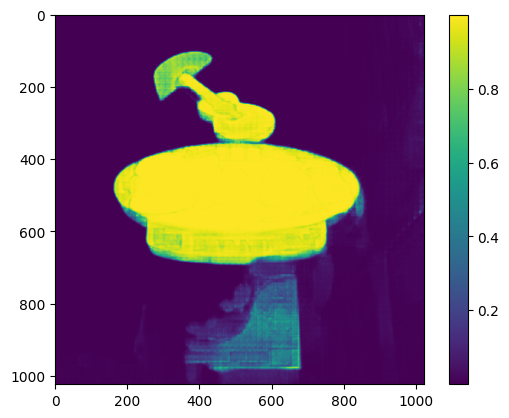

In [15]:
import matplotlib.pyplot as plt
plt.show()
plt.imshow(torch.squeeze(out[0]))
plt.colorbar()

/Users/jameskelly/miniconda3/envs/sam/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


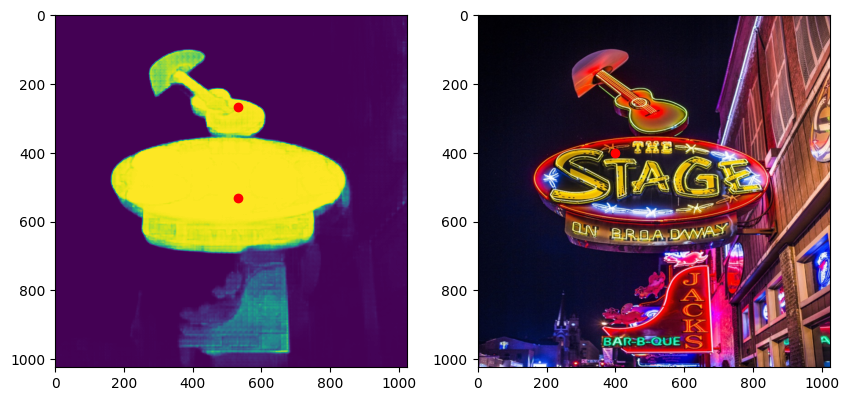

In [16]:
plt.figure(figsize=(10,20))
plt.subplot(1, 2, 1)
plt.imshow(torch.nn.functional.sigmoid(torch.squeeze(out[0])))
plt.plot([x*1024/770 for x in [400,400]], [x*1024/770 for x in [400,200]], 'ro')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.plot([400], [400], 'ro')
plt.show()

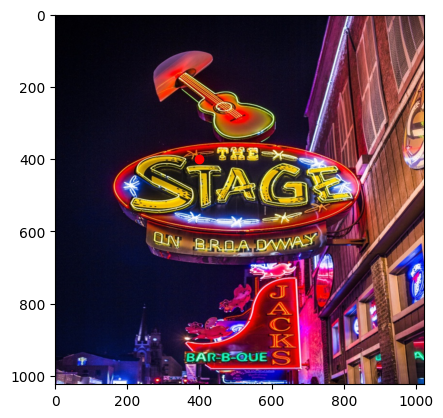

In [17]:
plt.imshow(image)
plt.plot([400], [400], 'ro')

In [18]:
(770/1024)*770

579.00390625

In [19]:
output_names = ["masks", "iou_predictions", "low_res_masks"]

In [20]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=torch.jit.TracerWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    output = "mobile_sam.onnx"
    with open("mobile_sam.onnx", "wb") as f:
        print(f"Exporting onnx model to {output}...")
        torch.onnx.export(
            onnx_model,
            tuple(dummy_inputs.values()),
            f,
            export_params=True,
            verbose=False,
            opset_version=17,
            do_constant_folding=True,
            input_names=list(dummy_inputs.keys()),
            output_names=output_names,
            dynamic_axes=dynamic_axes,
        )

Exporting onnx model to mobile_sam.onnx...


In [34]:
#assert onnxruntime_exists, "onnxruntime is required to quantize the model."
from onnxruntime.quantization import QuantType  # type: ignore
from onnxruntime.quantization.quantize import quantize_dynamic  # type: ignore

#print(f"Quantizing model and writing to {args.quantize_out}...")
quantize_dynamic(
    model_input="mobile_sam.onnx",
    model_output="mobile_sam_8bit.onnx",
    optimize_model=True,
    per_channel=False,
    reduce_range=False,
    weight_type=QuantType.QUInt8,
)

Ignore MatMul due to non constant B: /[/image_encoder/layers.1/blocks.0/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.1/blocks.0/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.1/blocks.1/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.1/blocks.1/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.0/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.0/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.1/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.1/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.2/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.2/attn/MatMul_1]
Ignore MatMul due to non constant B: /[/image_encoder/layers.2/blocks.3/attn/MatMul]
Ignore MatMul due to non constant B: /[/image_encoder/l

In [35]:
!ls -lh mobile_sam*.onnx

-rw-r--r--@ 1 jameskelly  staff    42M Jun 27 14:47 mobile_sam.onnx
-rw-r--r--@ 1 jameskelly  staff    23M Jun 27 15:02 mobile_sam_8bit.onnx


In [22]:
import onnxruntime

In [23]:
def to_numpy(tensor):
    return tensor.cpu().numpy()

In [24]:
ort_inputs = {k: to_numpy(v) for k, v in dummy_inputs.items()}
# set cpu provider default
providers = ["CPUExecutionProvider"]
ort_session = onnxruntime.InferenceSession(output, providers=providers)
out_onnx = ort_session.run(None, ort_inputs)

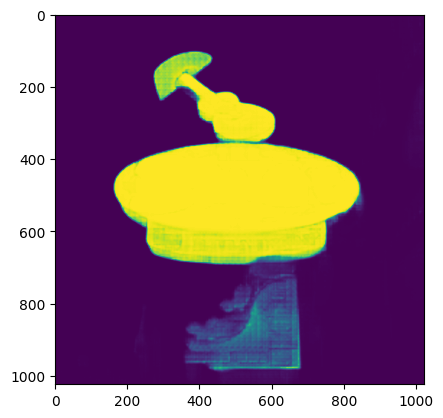

In [25]:
plt.figure()
plt.imshow(np.squeeze(out_onnx[0]))
plt.show()

In [25]:
!pip install coremltools

  Using cached coremltools-6.3.0-cp310-none-macosx_11_0_arm64.whl (1.9 MB)
  Using cached protobuf-3.20.3-py2.py3-none-any.whl (162 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.3
    Uninstalling protobuf-4.23.3:
      Successfully uninstalled protobuf-4.23.3


In [26]:
import coremltools as ct


In [28]:
with torch.no_grad():
    onnx_model.eval()
    model = onnx_model.cpu()
    model.requires_grad_(False)
    traced_model = torch.jit.trace(onnx_model, example_inputs=(dummy_inputs["x"], dummy_inputs["point_coords"]))

/Users/jameskelly/Code/MobileSAM/mobile_encoder/tiny_vit_sam.py:336: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert L == H * W, "input feature has wrong size"
/Users/jameskelly/Code/MobileSAM/mobile_encoder/tiny_vit_sam.py:136: TracerWarning: Using len to get tensor shape might cause the trace to be incorrect. Recommended usage would be tensor.shape[0]. Passing a tensor of different shape might lead to errors or silently give incorrect results.
  B = len(x)
/Users/jameskelly/Code/MobileSAM/segment_anything/utils/onnx.py:115: TracerWarning: torch.Tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In

In [29]:
traced_model

SamOnnxModel(
  original_name=SamOnnxModel
  (mask_decoder): MaskDecoder(
    original_name=MaskDecoder
    (transformer): TwoWayTransformer(
      original_name=TwoWayTransformer
      (layers): ModuleList(
        original_name=ModuleList
        (0): TwoWayAttentionBlock(
          original_name=TwoWayAttentionBlock
          (self_attn): Attention(
            original_name=Attention
            (q_proj): Linear(original_name=Linear)
            (k_proj): Linear(original_name=Linear)
            (v_proj): Linear(original_name=Linear)
            (out_proj): Linear(original_name=Linear)
          )
          (norm1): LayerNorm(original_name=LayerNorm)
          (cross_attn_token_to_image): Attention(
            original_name=Attention
            (q_proj): Linear(original_name=Linear)
            (k_proj): Linear(original_name=Linear)
            (v_proj): Linear(original_name=Linear)
            (out_proj): Linear(original_name=Linear)
          )
          (norm2): LayerNorm(orig

In [30]:
input_shape = ct.Shape(shape=(1,
                              ct.RangeDim(lower_bound=1, upper_bound=10, default=1),
                              2
                              ))

In [31]:
ct.convert(traced_model,
       inputs=[ct.ImageType("image", shape=[1,3,1024,1024], scale=1.0, bias=[0,0,0]),
              ct.TensorType(shape=input_shape, name="inputs")],
           outputs=[ct.ImageType(name="mask", color_layout=ct.colorlayout.GRAYSCALE)]
              )

Tuple detected at graph output. This will be flattened in the converted model.
Converting PyTorch Frontend ==> MIL Ops:  62%|██████▏   | 1246/1994 [00:00<00:00, 6003.85 ops/s]


RuntimeError: PyTorch convert function for op 'repeat_interleave' not implemented.

In [ ]:
import torchvision.transforms as T

In [ ]:
img_tensor = T.ToTensor()(image)

In [ ]:
x = mobile_sam.preprocess(img_tensor.unsqueeze(0))

In [ ]:
values = mobile_sam.image_encoder(x)

In [ ]:
values

In [ ]:
values.shape

In [ ]:
embed_dim

In [ ]:
embed_size

In [ ]:
mobile_sam.pixel_mean